In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import seaborn as sns
from LabUtils.Utils import mkdirifnotexists

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from LabData.DataAnalyses.TenK_Trajectories.biological_age.predict_age import work_dir, pred_dir, modality_name_mapping
#     work_dir, pred_dir, pred_residuals_fig_dir, load_ranked_residuals, Ys_dir, sm, r2_score, \
#     BodyMeasuresLoader, add_text_at_corner
sex_class_dir = os.path.join(work_dir, 'sex_classification')

In [8]:
fig_dir = mkdirifnotexists(os.path.join(work_dir, 'figures', 'figure3'))

In [206]:
cat_to_exclude = ['diet_questions', 'medical_conditions', 'medications']

min_max = lambda x: (x.min(), x.max())

def load_data(exclude=[], null=False):
    r = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude+exclude, axis=0)
    df_list = []
    for name in r.index:
        if null:
            d = pd.read_csv(os.path.join(sex_class_dir, name, 'LGBM_results_by_age_full_range_isnull.csv'), 
                        index_col=0).reset_index().melt(id_vars=['index', 'size'])
        else:
            d = pd.read_csv(os.path.join(sex_class_dir, name, 'LGBM_results_by_age_full_range.csv'), 
                            index_col=0).reset_index().melt(id_vars=['index', 'size'])
        d['name'] = modality_name_mapping[name]
        df_list.append(d)
    df = pd.concat(df_list, axis=0)
    df = df.sort_values(['index', 'value'], ascending=[True, False])
    df = df.applymap(lambda x: x.replace('(', '').replace(']', '').replace(', ', '-') if isinstance(x, str) else x)
    return df

def sex_class_forest_plot(ax, exclude=[]):
    df = load_data(exclude)
    
    sns.pointplot(data=df, x='value', y='name', hue='index', errorbar=min_max, join=False,
                  dodge=0.7, palette=sns.color_palette('Paired'), ax=ax, errwidth=2)
#     order=odds_matched.drop(cat_to_exclude).rename(index=modality_name_mapping).index
#     ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('Classification ROC AUC', fontsize=15)
    ax.legend(title='Age group', fontsize=15, loc='best', title_fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.axvline(x=0.5, linestyle='--', color='black')
    ax.set_title('Classification of sex by age group', fontsize=15)
    return df

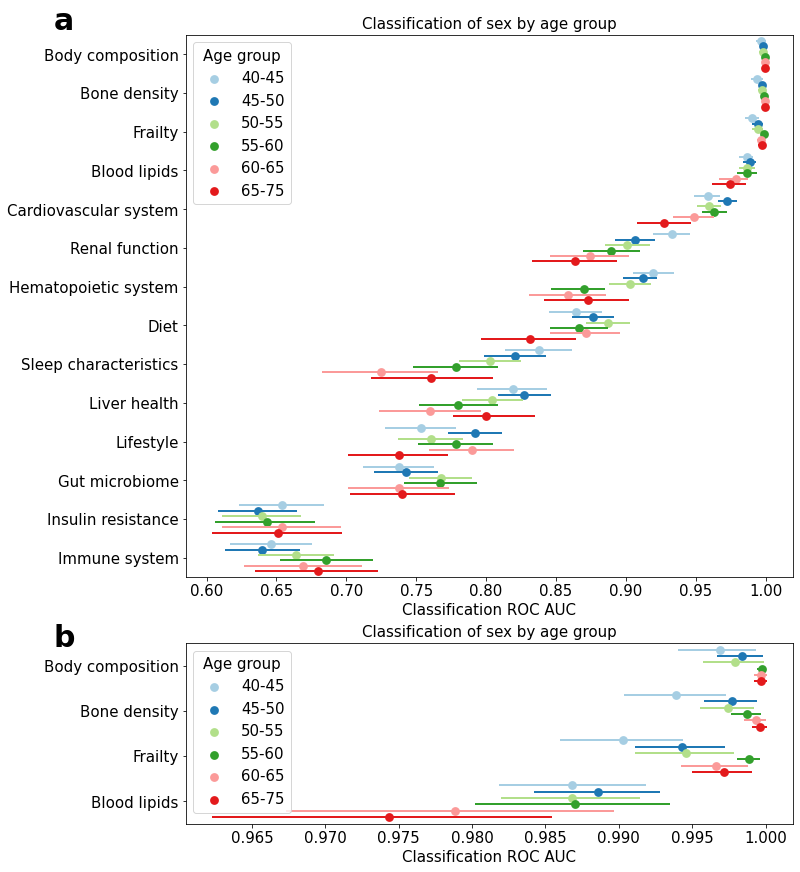

In [73]:
ax_dict = plt.figure(constrained_layout=True, figsize=(11, 12)).subplot_mosaic(
    """
    A
    A
    A
    B
    """,
    gridspec_kw={"wspace": 0, "hspace": 0},
)


df = sex_class_forest_plot(ax_dict['A'])
exclude=['immune_system', 'glycemic_status', 'microbiome', 'lifestyle', 'liver', 'sleep', 'diet', 
         'hematopoietic_system', 'renal_function', 'cardiovascular_system']
df = sex_class_forest_plot(ax_dict['B'], exclude)

ax_dict["A"].text(-0.2, 1.025, 'a', ha='center', va='center', transform=ax_dict["A"].transAxes, fontsize=30, weight='bold')
ax_dict["B"].text(-0.2, 1.025, 'b', ha='center', va='center', transform=ax_dict["B"].transAxes, fontsize=30, weight='bold')

plt.savefig(os.path.join(fig_dir, 'figure3.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure3.pdf'), dpi=300, bbox_inches='tight')

In [215]:
df = load_data()

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


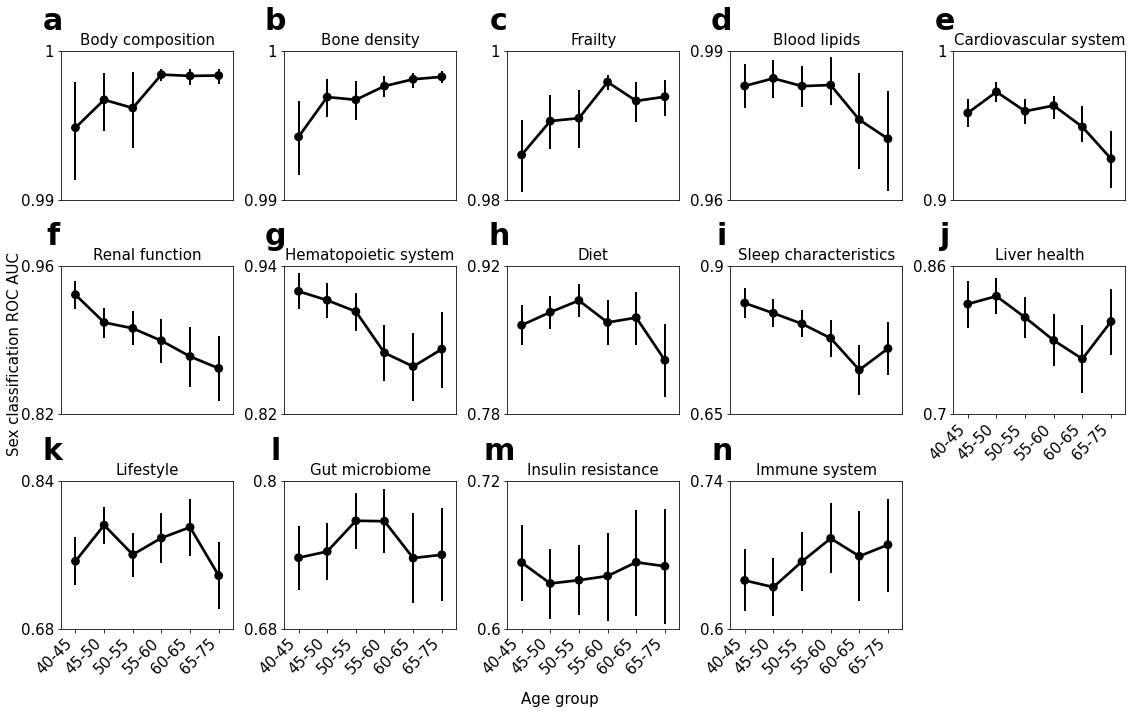

In [221]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=False, sharey=False, constrained_layout=True)

x_names = df['name'].unique()
pred_col = 'age'

for x_name, ax, letter in zip(x_names, axes.flatten(), 'abcdefghijklmno'):
#     male_xvals, male_yvals, female_xvals, female_yvals, male_r2_score, female_r2_score = get_lowess(x_name)
    
#     ax.plot(male_xvals, male_yvals, linewidth=3, color=male_color, label=r'$R^2$=%0.2g' % male_r2_score)
#     ax.plot(female_xvals, female_yvals, linewidth=3, color=female_color, label=r'$R^2$=%0.2g' % female_r2_score)
    
    sns.pointplot(data=df[df.name == x_name], x='index', y='value', errorbar=min_max, join=True,
                  dodge=0.7, ax=ax, errwidth=2, color='black')

    ax.set_ylabel('')
    ax.set_xlabel('', fontsize=15)
#     ax.legend(title='Age group', fontsize=15, loc='best', title_fontsize=15)
#     ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.axvline(x=0.5, linestyle='--', color='black')
#     ax.set_title('Classification of sex by age group', fontsize=15)

#     ax.set_xticks([40, 50, 60, 70])
#     ax.set_yticks([40, 50, 60, 70])

    ax.set_title(x_name, fontsize=15)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#     ax.set_xticklabels('', rotation=45, ha='right')
    ax.axes.get_xaxis().set_visible(False)
#     ax.legend(loc='upper left')
    ax.set_yticks((ax.get_yticks().min(), ax.get_yticks().max()))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

    ax.tick_params(labelsize=15)
    if letter != 'o':
        ax.text(-0.05, 1.2, letter, ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')

for ax_i in range(5):
    ax = axes[-1, ax_i]
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax = axes[-1, -1]
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_yticklabels('', rotation=45, ha='right')
# ax.set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=45, ha='right')
# ax.tick_params(labelsize=15, left=False)
# ax.axes.get_yaxis().set_visible(False)
ax.axis('off')

ax = axes[1, -1]
ax.axes.get_xaxis().set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# costume legend
# from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color=male_color, lw=4),
#                 Line2D([0], [0], color=female_color, lw=4)]

# ax.legend(custom_lines, ['Male', 'Female'], ncol=1, bbox_to_anchor=(0, 0.5), fancybox=True, fontsize=15, loc='center left')

# ax = axes[1, -1]
# ax.axes.get_xaxis().set_visible(T)
# ax.set_xticks(axes[-1, 0].get_xticks())
# ax.set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=45, ha='right')


fig.supxlabel('Age group', fontsize=15)
fig.supylabel('Sex classification ROC AUC', fontsize=15)



fig.tight_layout()


plt.savefig(os.path.join(fig_dir, 'figure3_supp_v2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure3_supp_v2.pdf'), dpi=300, bbox_inches='tight')

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


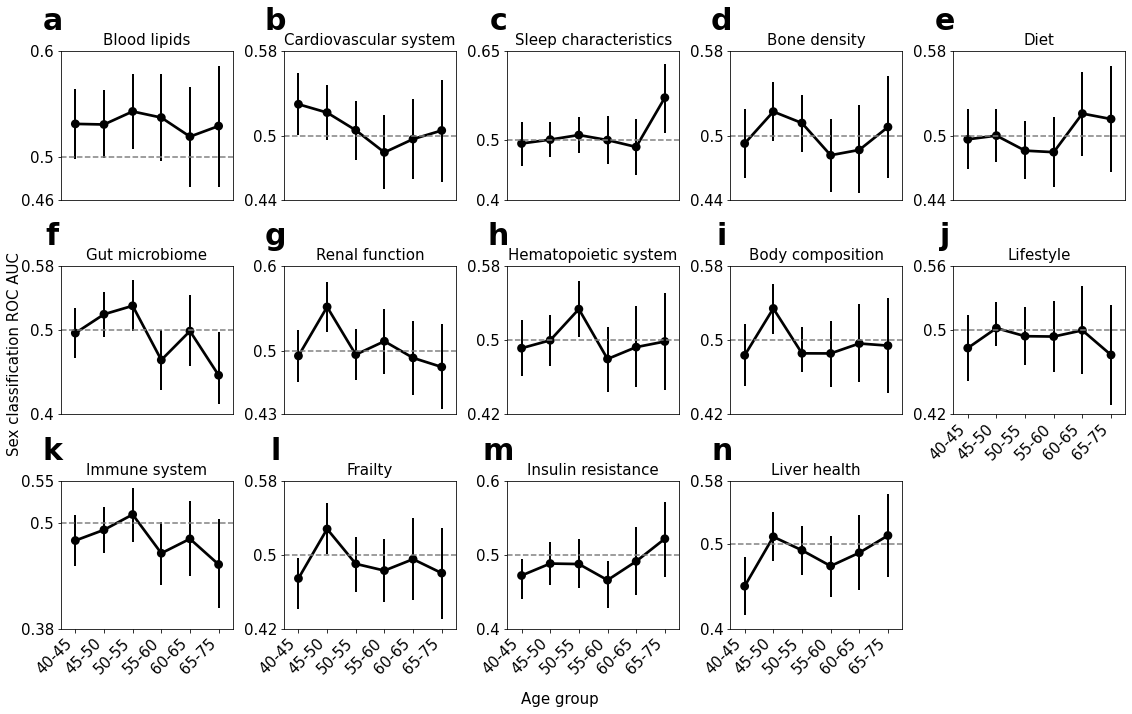

In [225]:
df = load_data(null=True)

from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=False, sharey=False, constrained_layout=True)

x_names = df['name'].unique()
pred_col = 'age'

for x_name, ax, letter in zip(x_names, axes.flatten(), 'abcdefghijklmno'):
#     male_xvals, male_yvals, female_xvals, female_yvals, male_r2_score, female_r2_score = get_lowess(x_name)
    
#     ax.plot(male_xvals, male_yvals, linewidth=3, color=male_color, label=r'$R^2$=%0.2g' % male_r2_score)
#     ax.plot(female_xvals, female_yvals, linewidth=3, color=female_color, label=r'$R^2$=%0.2g' % female_r2_score)
    
    sns.pointplot(data=df[df.name == x_name], x='index', y='value', errorbar=min_max, join=True,
                  dodge=0.7, ax=ax, errwidth=2, color='black')

    ax.set_ylabel('')
    ax.set_xlabel('', fontsize=15)
#     ax.legend(title='Age group', fontsize=15, loc='best', title_fontsize=15)
#     ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.axvline(x=0.5, linestyle='--', color='black')
#     ax.set_title('Classification of sex by age group', fontsize=15)

#     ax.set_xticks([40, 50, 60, 70])
#     ax.set_yticks([40, 50, 60, 70])

    ax.set_title(x_name, fontsize=15)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#     ax.set_xticklabels('', rotation=45, ha='right')
    ax.axes.get_xaxis().set_visible(False)
#     ax.legend(loc='upper left')
    ax.set_yticks((ax.get_yticks().min(), 0.5, ax.get_yticks().max()))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

    ax.tick_params(labelsize=15)
    if letter != 'o':
        ax.text(-0.05, 1.2, letter, ha='center', va='center', transform=ax.transAxes, fontsize=30, weight='bold')
        ax.axhline(y=0.5, linestyle='--', color='grey')

for ax_i in range(5):
    ax = axes[-1, ax_i]
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax = axes[-1, -1]
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_yticklabels('', rotation=45, ha='right')
# ax.set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=45, ha='right')
# ax.tick_params(labelsize=15, left=False)
# ax.axes.get_yaxis().set_visible(False)
ax.axis('off')

ax = axes[1, -1]
ax.axes.get_xaxis().set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# costume legend
# from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color=male_color, lw=4),
#                 Line2D([0], [0], color=female_color, lw=4)]

# ax.legend(custom_lines, ['Male', 'Female'], ncol=1, bbox_to_anchor=(0, 0.5), fancybox=True, fontsize=15, loc='center left')

# ax = axes[1, -1]
# ax.axes.get_xaxis().set_visible(T)
# ax.set_xticks(axes[-1, 0].get_xticks())
# ax.set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=45, ha='right')


fig.supxlabel('Age group', fontsize=15)
fig.supylabel('Sex classification ROC AUC', fontsize=15)



fig.tight_layout()


plt.savefig(os.path.join(fig_dir, 'figure3_supp_v2_isnull.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure3_supp_v2_isnull.pdf'), dpi=300, bbox_inches='tight')

In [10]:
os.listdir(os.path.join(sex_class_dir))

['liver',
 'diet_questions',
 'medical_conditions',
 'glycemic_status',
 'diet',
 'blood_lipids',
 'bone_density',
 'medications',
 'frailty',
 'hematopoietic_system',
 'cardiovascular_system',
 'lifestyle',
 'microbiome',
 'sleep',
 'renal_function',
 'body_composition',
 'immune_system']

In [150]:


x_name = 'bone_density'
df = pd.read_csv(os.path.join(sex_class_dir, x_name, '%s_X.csv' % x_name), index_col=0)
y_age = df['age']
y_age_bin = pd.cut(y_age, bins=[40, 45, 50, 55, 60, 65, 75])
df.drop('age', axis=1, inplace=True)
y_gender = pd.read_csv(os.path.join(sex_class_dir, x_name, 'y.csv'), index_col=0)['gender']


# df = df[use_cols].dropna(how='all', axis=1)
df.dropna(how='all', axis=1, inplace=True)
df = df.loc[:, df.std() != 0]
df.fillna(df.median(), inplace=True)
df = df.apply(lambda x: (x-x.mean()) / x.std())


n_components = min(5, df.shape[1])
pca = PCA(n_components=n_components)
df_pcs = pd.DataFrame(pca.fit_transform(df), index=df.index, columns=['PC%d'%d for d in range(1, n_components+1)])
df_pcs

,PC1,PC2,PC3,PC4,PC5
RegistrationCode,,,,,
10K_1287606272,-6.111616,12.691984,-2.527433,1.698868,-0.180112
10K_1421463295,-9.603727,2.225716,-1.396152,-1.115301,2.145071
10K_1547928889,-4.131989,0.794612,2.516994,2.203625,1.791553
10K_1581346698,-0.298098,8.354498,3.690736,0.515665,-3.074704
10K_1592203214,-9.371165,3.263555,0.939998,-1.520386,-0.445732
...,...,...,...,...,...
10K_9813823840,5.203235,-5.529920,-0.062580,-3.833927,2.541664
10K_1361711195,7.525678,-6.132582,-1.317510,-3.096519,1.055035
10K_2878714594,-6.338332,-4.240828,-1.469273,-2.254809,-1.738536


In [195]:
def boostrap_pdist(x1, x2, bs_rounds=10):
    dist = []
    for i in range(bs_rounds):
        np.random.seed(i)
        x1_idx = np.random.choice(x1.index, size=x1.shape[0], replace=True)
        x2_idx = np.random.choice(x2.index, size=x2.shape[0], replace=True)
        dist.append(pdist(pd.DataFrame([x1.loc[x1_idx].mean(), x2.loc[x2_idx].mean()])))
    return pd.Series(dist).quantile([0.025, 0.975])

def boostrap_cdist(distances, bs_rounds=10):
    dist = []
    for i in range(bs_rounds):
        np.random.seed(i)
        x1_idx = np.random.choice(range(distances.shape[0]), size=distances.shape[0], replace=True)
        x2_idx = np.random.choice(range(distances.shape[1]), size=distances.shape[1], replace=True)
        dist.append(distances[x1_idx][:, x2_idx].mean())
    return pd.Series(dist).quantile([0.025, 0.975])

def halfed_cdist(distances, bs_rounds=10):
    dist = []
    for i in range(bs_rounds):
        np.random.seed(i)
        x_idx = np.random.choice(range(distances.shape[0]), size=int(distances.shape[0] / 2), replace=False)
        y_idx = list(set(range(distances.shape[0])) - set(x_idx))
        dist.append(distances[x_idx][:, y_idx].mean())
    return pd.Series(dist).quantile([0.025, 0.975])

In [203]:
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, cdist

def load_pca_distances(n_components=20, exclude=[], only_return_pcs=False):
    r = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude+exclude, axis=0)
    df_list = []
    pcs_dic = {}
    for x_name in r.index:
        print(x_name)
        df = pd.read_csv(os.path.join(sex_class_dir, x_name, '%s_X.csv' % x_name), index_col=0)
        y_age = df['age']
        y_age_bin = pd.cut(y_age, bins=[40, 45, 50, 55, 60, 65, 75])
        df.drop('age', axis=1, inplace=True)
        y_gender = pd.read_csv(os.path.join(sex_class_dir, x_name, 'y.csv'), index_col=0)['gender']


        # df = df[use_cols].dropna(how='all', axis=1)
        df.dropna(how='all', axis=1, inplace=True)
        df = df.loc[:, df.std() != 0]
        df.fillna(df.median(), inplace=True)
        df = df.apply(lambda x: (x-x.mean()) / x.std())

        n_components = min(n_components, df.shape[1])
        pca = PCA(n_components=n_components)
        df_pcs = pd.DataFrame(pca.fit_transform(df), index=df.index, 
                              columns=['PC%d'%d for d in range(1, n_components+1)])

        pcs_dic[x_name] = {'pca': df_pcs, 'age': y_age, 'gender': y_gender}
        if not only_return_pcs:
            for b in y_age_bin.unique().sort_values():
                male_x, female_x = df_pcs.loc[(y_gender==1) & (y_age_bin == b)], df_pcs.loc[(y_gender==0) & (y_age_bin == b)]
                
                d = cdist(male_x, female_x)
                d25, d975 = boostrap_cdist(d)
                
    #             print(b, d, d25)
                df_list.append(pd.DataFrame([[x_name, str(b), 'auc', d.mean(), male_x.shape[0], female_x.shape[0], 'male-female']]))
                df_list.append(pd.DataFrame([[x_name, str(b), 2.5, d25, male_x.shape[0], female_x.shape[0], 'male-female']]))
                df_list.append(pd.DataFrame([[x_name, str(b), 97.5, d975, male_x.shape[0], female_x.shape[0], 'male-female']]))
                
                d = cdist(male_x, male_x)
                d25, d975 = halfed_cdist(d)
                
                df_list.append(pd.DataFrame([[x_name, str(b), 'auc', d.mean(), male_x.shape[0], female_x.shape[0], 'male-male']]))
                df_list.append(pd.DataFrame([[x_name, str(b), 2.5, d25, male_x.shape[0], female_x.shape[0], 'male-male']]))
                df_list.append(pd.DataFrame([[x_name, str(b), 97.5, d975, male_x.shape[0], female_x.shape[0], 'male-male']]))
                
                d = cdist(female_x, female_x)
                d25, d975 = halfed_cdist(d)
                
                df_list.append(pd.DataFrame([[x_name, str(b), 'auc', d.mean(), male_x.shape[0], female_x.shape[0], 'female-female']]))
                df_list.append(pd.DataFrame([[x_name, str(b), 2.5, d25, male_x.shape[0], female_x.shape[0], 'female-female']]))
                df_list.append(pd.DataFrame([[x_name, str(b), 97.5, d975, male_x.shape[0], female_x.shape[0], 'female-female']]))
    if only_return_pcs:
        return pcs_dic
    df = pd.concat(df_list)
    df = df.rename(columns={0: 'name', 1: 'age_bin', 2: 'variable', 3: 'value', 4: 'male_size', 5: 'female_size', 6: 'sex'})
    df = df.applymap(lambda x: x.replace('(', '').replace(']', '').replace(', ', '-') if isinstance(x, str) else x)

    return df
    


In [161]:
pcs_dic = load_pca_distances(only_return_pcs=True)

blood_lipids
cardiovascular_system
immune_system
liver
renal_function
bone_density
microbiome
body_composition
frailty
lifestyle
diet
hematopoietic_system
glycemic_status
sleep


In [204]:
df = load_pca_distances()
df

blood_lipids
cardiovascular_system
immune_system
liver
renal_function
bone_density
microbiome
body_composition
frailty
lifestyle
diet
hematopoietic_system
glycemic_status
sleep


,name,age_bin,variable,value,male_size,female_size,sex
0,blood_lipids,40-45,auc,49.065802,549,559,male-female
0,blood_lipids,40-45,2.5,48.697855,549,559,male-female
0,blood_lipids,40-45,97.5,50.039755,549,559,male-female
0,blood_lipids,40-45,auc,47.472263,549,559,male-male
0,blood_lipids,40-45,2.5,47.531703,549,559,male-male
...,...,...,...,...,...,...,...
0,sleep,65-75,2.5,6.759884,220,216,male-male
0,sleep,65-75,97.5,6.817641,220,216,male-male
0,sleep,65-75,auc,8.380463,220,216,female-female
0,sleep,65-75,2.5,8.404889,220,216,female-female


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


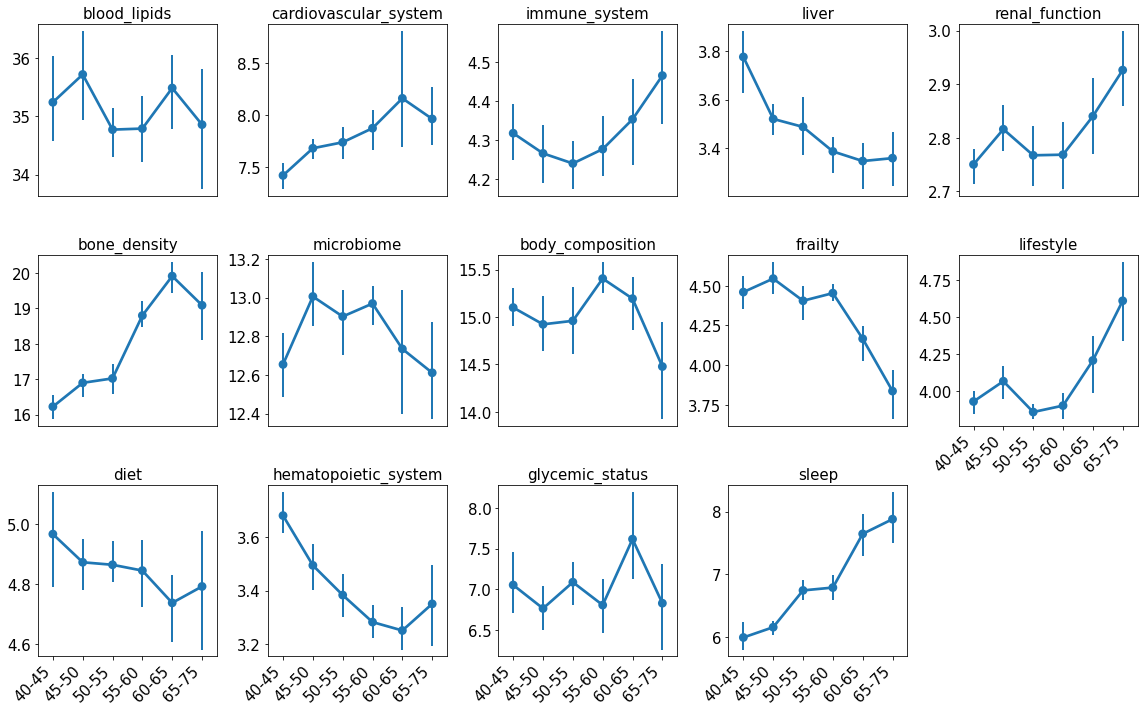

In [198]:
fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=False, sharey=False, constrained_layout=True)

x_names = df['name'].unique()

for x_name, ax in zip(x_names, axes.flatten()):
#     male_xvals, male_yvals, female_xvals, female_yvals, male_r2_score, female_r2_score = get_lowess(x_name)
    
#     ax.plot(male_xvals, male_yvals, linewidth=3, color=male_color, label=r'$R^2$=%0.2g' % male_r2_score)
#     ax.plot(female_xvals, female_yvals, linewidth=3, color=female_color, label=r'$R^2$=%0.2g' % female_r2_score)
    
    sns.pointplot(data=df[(df.name == x_name) & (df['sex'] == 'male-female')], x='age_bin', y='value', errorbar=min_max, join=True,
                  dodge=0.7, ax=ax, errwidth=2)

    ax.set_ylabel('')
    ax.set_xlabel('', fontsize=15)
#     ax.legend(title='Age group', fontsize=15, loc='best', title_fontsize=15)
#     ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.axvline(x=0.5, linestyle='--', color='black')
#     ax.set_title('Classification of sex by age group', fontsize=15)

#     ax.set_xticks([40, 50, 60, 70])
#     ax.set_yticks([40, 50, 60, 70])

    ax.set_title(x_name, fontsize=15)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#     ax.set_xticklabels('', rotation=45, ha='right')
    ax.axes.get_xaxis().set_visible(False)
#     ax.legend(loc='upper left')

    ax.tick_params(labelsize=15)

for ax_i in range(5):
    ax = axes[-1, ax_i]
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax = axes[-1, -1]
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_yticklabels('', rotation=45, ha='right')
# ax.set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=45, ha='right')
# ax.tick_params(labelsize=15, left=False)
# ax.axes.get_yaxis().set_visible(False)
ax.axis('off')

ax = axes[1, -1]
ax.axes.get_xaxis().set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# costume legend
# from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color=male_color, lw=4),
#                 Line2D([0], [0], color=female_color, lw=4)]

# ax.legend(custom_lines, ['Male', 'Female'], ncol=1, bbox_to_anchor=(0, 0.5), fancybox=True, fontsize=15, loc='center left')

# ax = axes[1, -1]
# ax.axes.get_xaxis().set_visible(T)
# ax.set_xticks(axes[-1, 0].get_xticks())
# ax.set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=45, ha='right')


# fig.supxlabel('Age group', fontsize=15)
# fig.supylabel('Classification ROC AUC of sex by age group', fontsize=15)



fig.tight_layout()


# plt.savefig(os.path.join(fig_dir, 'figure3_supp_v2.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(fig_dir, 'figure3_supp_v2.pdf'), dpi=300, bbox_inches='tight')

/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


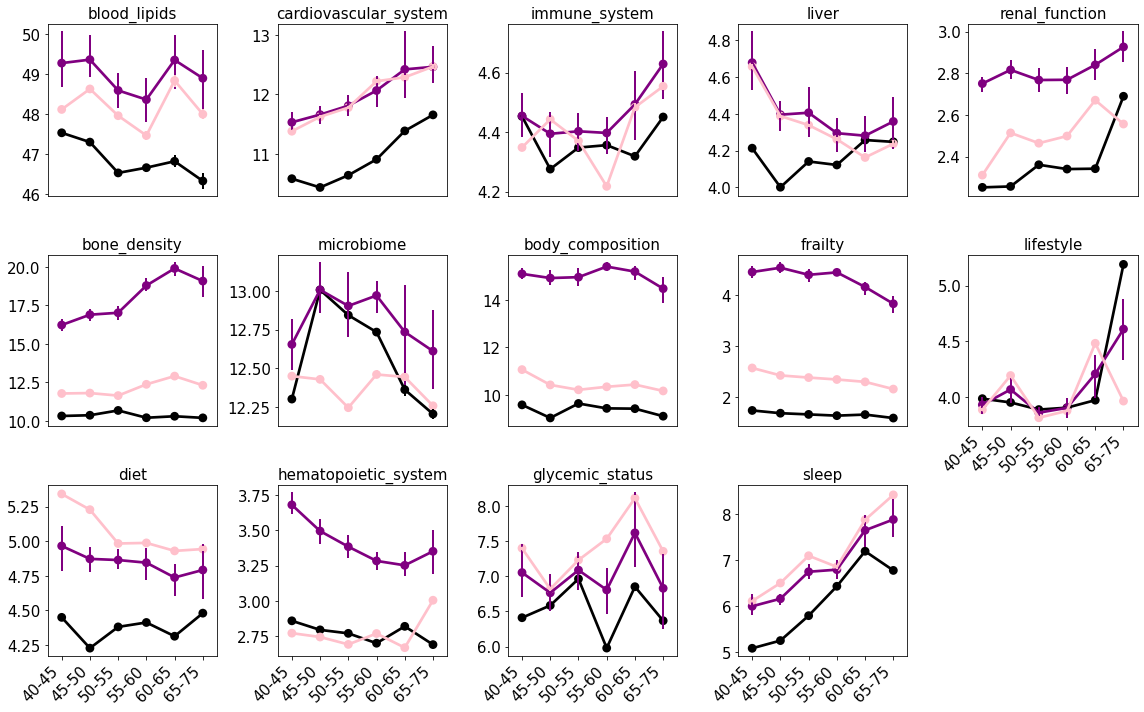

In [205]:
fig, axes = plt.subplots(3, 5, figsize=(16, 10), sharex=False, sharey=False, constrained_layout=True)

x_names = df['name'].unique()

for x_name, ax in zip(x_names, axes.flatten()):
#     male_xvals, male_yvals, female_xvals, female_yvals, male_r2_score, female_r2_score = get_lowess(x_name)
    
#     ax.plot(male_xvals, male_yvals, linewidth=3, color=male_color, label=r'$R^2$=%0.2g' % male_r2_score)
#     ax.plot(female_xvals, female_yvals, linewidth=3, color=female_color, label=r'$R^2$=%0.2g' % female_r2_score)
    for sex, color in zip(['male-male', 'male-female', 'female-female'], ['black', 'purple', 'pink']):
        sns.pointplot(data=df[(df.name == x_name) & (df['sex'] == sex)], x='age_bin', y='value', errorbar=min_max, join=True,
                      dodge=0.7, ax=ax, errwidth=2, label=sex, color=color)

    ax.set_ylabel('')
    ax.set_xlabel('', fontsize=15)
#     ax.legend(title='Age group', fontsize=15, loc='best', title_fontsize=15)
#     ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.axvline(x=0.5, linestyle='--', color='black')
#     ax.set_title('Classification of sex by age group', fontsize=15)

#     ax.set_xticks([40, 50, 60, 70])
#     ax.set_yticks([40, 50, 60, 70])

    ax.set_title(x_name, fontsize=15)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#     ax.set_xticklabels('', rotation=45, ha='right')
    ax.axes.get_xaxis().set_visible(False)
#     ax.legend(loc='upper left')

    ax.tick_params(labelsize=15)

for ax_i in range(5):
    ax = axes[-1, ax_i]
    ax.axes.get_xaxis().set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax = axes[-1, -1]
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_yticklabels('', rotation=45, ha='right')
# ax.set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=45, ha='right')
# ax.tick_params(labelsize=15, left=False)
# ax.axes.get_yaxis().set_visible(False)
ax.axis('off')

ax = axes[1, -1]
ax.axes.get_xaxis().set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# costume legend
# from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color=male_color, lw=4),
#                 Line2D([0], [0], color=female_color, lw=4)]

# ax.legend(custom_lines, ['Male', 'Female'], ncol=1, bbox_to_anchor=(0, 0.5), fancybox=True, fontsize=15, loc='center left')

# ax = axes[1, -1]
# ax.axes.get_xaxis().set_visible(T)
# ax.set_xticks(axes[-1, 0].get_xticks())
# ax.set_xticklabels(axes[-1, 0].get_xticklabels(), rotation=45, ha='right')


# fig.supxlabel('Age group', fontsize=15)
# fig.supylabel('Classification ROC AUC of sex by age group', fontsize=15)



fig.tight_layout()


# plt.savefig(os.path.join(fig_dir, 'figure3_supp_v2.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(fig_dir, 'figure3_supp_v2.pdf'), dpi=300, bbox_inches='tight')